# Link iNaturalist observations to TRY

Link iNaturalist vascular plant observations to the previously created trait TRY summary statistics.

This section covers:

- Load data
- Link GBIF and TRY
- Fuzzy merge
- Log trait values conversion
- Number of observations per trait
- Plot observation density after linking

## Assignments
- Repeat the workflow but instead of the mean, calculate the standard deviation (for this, you also have to change the workflow in Chapter 2).

## Packages, etc.

In [1]:
import pandas as pd
import os
import numpy as np

# fuzzy matching
#import rapidfuzz
from rapidfuzz import process, fuzz

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import cartopy.crs as ccrs # plot maps
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load data

We load the GBIF vascular plant observations and the TRY summary stats per species.

In [3]:
gbif = pd.read_csv("exports/gbif_preporcessed.csv")
gbif.head(3)

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,hasCoordinate,species,decimalLongitude_cell,decimalLatitude_cell,hex
0,891081513,45.314152,-80.340602,2012-05-18T04:48:53,Cypripedium acaule Aiton,Plantae,Tracheophyta,Asparagales,Orchidaceae,Cypripedium,True,Cypripedium acaule,50,54,842b9e5ffffffff
1,1265894626,46.151281,-123.956064,2016-04-21T01:14:57,Fragaria chiloensis (L.) Duchesne,Plantae,Tracheophyta,Rosales,Rosaceae,Fragaria,True,Fragaria chiloensis,28,55,8428f17ffffffff
2,1269563034,35.352020,-83.861525,2016-05-16T23:14:34,Pyrularia pubera Michx.,Plantae,Tracheophyta,Santalales,Cervantesiaceae,Pyrularia,True,Pyrularia pubera,49,49,8444ca9ffffffff


Load trait measurments with consolidated species name:

In [4]:
TRY = pd.read_csv("exports/TRY_summary_stats.csv")
print(TRY.shape)
TRY.head()

(49618, 34)


C:\Users\teja\AppData\Local\Temp\ipykernel_8300\2460484989.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  TRY = pd.read_csv("data/TRY_summary_stats.csv")


,Species,Stem specific density (SSD),Root rooting depth,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Leaf nitrogen (N) per mass,Leaf phosphorus (P) per mass,Plant Height,Seed diameter,Seed mass,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,NaN,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
1,ABACABA (PALM),0.67182258,2.188645968,13.752224134999999,474.5692781,25.32521345,1.253181666,8.4296382075,0.2313252895,46.814951185,...,2.4796274765,5.936477324,38.54777807,286.83885685,806.1851291,1540.9771784999998,1629.9629989999999,991.6321591999999,1292.5800945,2.6455549229999997
2,ABIU CASCA,0.49697818080000006,0.8950037030000001,6.2474206146,500.14809206,12.69680008,1.1448929794,13.550312633999999,0.38141308659999995,17.222437812000003,...,30.945200002,11.971509082,12.890331503999999,790.67177572,1499.2807388,1884.3254176000003,127.19104564,164.44703828,134.33358565999998,2.3251470896
3,ABIU CUTITI,0.47722341749999997,0.94460775825,6.634051281375,497.942213275,11.87797663625,1.194187159875,13.245605475,0.157331747125,15.91704585,...,28.611930386250002,11.13826751375,14.919168916250001,777.4280522624999,1436.118488875,2397.98345525,126.66614393750001,179.9558873,155.4498817625,2.269552209125
4,ABIU PITOMBA,0.526880003,1.117701795,6.008566008,499.8086168,12.51477023,1.147831116,14.29486693,0.708226331,17.32767837,...,28.94036888,12.00787732,12.9384099,819.4506614,1483.106728,1452.674352,121.1756689,165.3657456,129.8723178,2.173391932


In [5]:
TRY.shape

(49618, 34)

In [6]:
gbif.shape

(3606155, 15)

In [7]:
# check that we have only unique observation ID's
gbif["gbifID"].nunique()

3606155

## Link GBIF and TRY

Non-fuzzy merge with TRY summary stats on **consolidated TRY species name**:


In [11]:
gbif_TRY = pd.merge(gbif, TRY, 
                    left_on= ['species'],
                    right_on= ['Species'], 
                    how='inner') # only results in matched records where both datasets have the same species name (alternatives would be "left" and "right")
gbif_TRY.drop(columns=['Species'], inplace=True)
gbif_TRY.head(3)

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,891081513,45.314152,-80.340602,2012-05-18T04:48:53,Cypripedium acaule Aiton,Plantae,Tracheophyta,Asparagales,Orchidaceae,Cypripedium,...,7.072594903500001,0.8331424295000001,9.715277619,473.80963425,765.20177555,10023.00123,1542.2710935,2139.9079565,1226.200514,9.316072562999999
1,1265894626,46.151281,-123.956064,2016-04-21T01:14:57,Fragaria chiloensis (L.) Duchesne,Plantae,Tracheophyta,Rosales,Rosaceae,Fragaria,...,0.788768,4.582629,25.337936,343.997791,460.161207,8621.633791,945.783979,531.691722,798.397504,3.368203
2,1269563034,35.352020,-83.861525,2016-05-16T23:14:34,Pyrularia pubera Michx.,Plantae,Tracheophyta,Santalales,Cervantesiaceae,Pyrularia,...,3.109954,11.408596,32.7967,237.935558,824.812513,718.602906,633.168228,492.229711,923.512746,3.636029


Check how many of the observations were matched:

In [12]:
print('TRY consolidated species:')
print(TRY["Species"].nunique())
print('GBIF species:')
print(gbif["scientificName"].nunique())
print('Matched species:')
print(gbif_TRY["species"].nunique())

# percentage of iNat observations linked with at least one TRY trait
print('percentage of GBIF observations linked with at least one TRY trait:')
print(round(len(gbif_TRY)/len(gbif)*100, 1), "%")

TRY consolidated species:
49617
GBIF species:
73492
Matched species:
21054
percentage of GBIF observations linked with at least one TRY trait:
78.5 %


## Fuzzy merge
Often, species names have typos or differ in their complexity (e.g. may include author names). The above used matching routine only considers matches when the strings (species names) are exactly the same. To overcome this limitation, we can use fuzzy matching, which can match strings that are relatively similar. The "relatively" can be defined by the parameter ```score_cutoff``` (see below).

In [13]:
gbif_rest = gbif[~gbif.gbifID.isin(gbif_TRY['gbifID'])]
print("Number of unmatched observations", gbif_rest.shape)
print("Number of unmatched species", gbif_rest.species.nunique())

Number of unmatched observations (775097, 15)
Number of unmatched species 41824


Get only unique species names left in gbif unmatched observations:

In [14]:
gbif_rest_unique = gbif_rest.drop_duplicates(subset=['scientificName'])
gbif_rest_unique.head(2)

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,hasCoordinate,species,decimalLongitude_cell,decimalLatitude_cell,hex
12,2244338658,-43.115774,171.703111,2019-02-13T03:19:38,Azorella pallida (Kirk) Kirk,Plantae,Tracheophyta,Apiales,Apiaceae,Azorella,True,Azorella pallida,176,10,84da955ffffffff
13,1883456948,30.193805,-98.439561,2018-07-10T08:58:09,Coryphantha sulcata (Engelm.) Britton & Rose,Plantae,Tracheophyta,Caryophyllales,Cactaceae,Coryphantha,True,Coryphantha sulcata,41,47,8448989ffffffff


Get only unique unmatched TRY species names:

In [15]:
TRY_rest = TRY[~TRY.Species.isin(gbif_TRY['species'])]
TRY_rest_unique = TRY_rest.drop_duplicates(subset=['Species'])

TRY_rest_unique.head(2)

,Species,Stem specific density (SSD),Root rooting depth,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Leaf nitrogen (N) per mass,Leaf phosphorus (P) per mass,Plant Height,Seed diameter,Seed mass,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
1,ABACABA (PALM),0.67182258,2.188645968,13.752224134999999,474.5692781,25.32521345,1.253181666,8.4296382075,0.2313252895,46.814951185,...,2.4796274765,5.936477324,38.54777807,286.83885685,806.1851291,1540.9771784999998,1629.9629989999999,991.6321591999999,1292.5800945,2.6455549229999997
2,ABIU CASCA,0.49697818080000006,0.8950037030000001,6.2474206146,500.14809206,12.69680008,1.1448929794,13.550312633999999,0.38141308659999995,17.222437812000003,...,30.945200002,11.971509082,12.890331503999999,790.67177572,1499.2807388,1884.3254176000003,127.19104564,164.44703828,134.33358565999998,2.3251470896


Run the fuzzy matching (this might take a while)

In [16]:
# define choices and queries (expect about 10 minutes to run)
choices = TRY_rest_unique["Species"].apply(str)
queries = gbif_rest_unique["scientificName"]

# score-cutoff is a threshold used on the similarity metric (similarity between choices and queries)
score_sort = [(x,) + i
             for x in queries
             for i in process.extract(x, choices, score_cutoff=90, scorer=fuzz.token_sort_ratio) ]

fuzzy_matches = pd.DataFrame(score_sort)
fuzzy_matches.head()

,0,1,2,3
0,Monotropa hypopitys L.,Monotropa hypopitys,92.682927,30587
1,Elaeagnus angustifolia L.,Eleagnus angustifolia,91.304348,16028
2,Blechnum orientale L.,Blechnum orientale,92.307692,5854
3,Juncus trifidus L.,Juncus trifidus,90.909091,25079
4,Ozothamnus turbinatus DC.,Ozothamnus turbinatus,91.304348,33070


This can be quite a long process. Let´s store the data just in case. Save fuzzy match to ```.csv```:

In [19]:
os.makedirs("exports", exist_ok=True)
fuzzy_matches.to_csv("exports/TRY_gbif_fuzzy_matches.csv", sep = "\t",index=False)

Reload fuzzy matches:

In [20]:
fuzzy_matches =  pd.read_csv("exports/TRY_gbif_fuzzy_matches.csv", sep = "\t")
fuzzy_matches.head()

,0,1,2,3
0,Monotropa hypopitys L.,Monotropa hypopitys,92.682927,30587
1,Elaeagnus angustifolia L.,Eleagnus angustifolia,91.304348,16028
2,Blechnum orientale L.,Blechnum orientale,92.307692,5854
3,Juncus trifidus L.,Juncus trifidus,90.909091,25079
4,Ozothamnus turbinatus DC.,Ozothamnus turbinatus,91.304348,33070


Rename the columns and merge with the data frame of the unmatched observations


In [21]:
fuzzy_matches.rename(columns = {'0':'scientificName'}, inplace = True)
fuzzy_matches.rename(columns = {'1':'fuzzyName'}, inplace = True)
gbif_rest_fuzzy = pd.merge(gbif_rest, fuzzy_matches, on='scientificName', how='inner')

Merge with TRY:

In [22]:
TRY = pd.read_csv("exports/TRY_summary_stats.csv")

TRY.rename(columns = {'Species':'fuzzyName'}, inplace = True)
gbif_TRY_fuzzy_1 = pd.merge(gbif_rest_fuzzy, TRY, on='fuzzyName', how='inner')

#gbif_TRY_fuzzy_rest = gbif_rest_fuzzy[~gbif_rest_fuzzy.gbifID.isin(gbif_TRY_fuzzy_1['gbifID'])]

# drop the by products (columns) from the fuzzy matching
gbif_TRY_fuzzy_1= gbif_TRY_fuzzy_1.drop(columns=["fuzzyName", "2", "3"])


C:\Users\teja\AppData\Local\Temp\ipykernel_8300\742126083.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  TRY = pd.read_csv("exports/TRY_summary_stats.csv")


In [198]:
print("shape", gbif_TRY_fuzzy_1.shape)
gbif_TRY_fuzzy_1.head(1)

shape (13, 48)


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,2611165247,54.86414,83.04772,2020-04-27T12:34:26,Hypochaeris maculata L.,Plantae,Tracheophyta,Asterales,Asteraceae,Trommsdorffia,...,4.714944,10.770342,8.517896,329.941256,862.69066,11210.084865,2152.198204,2103.785752,3081.909483,8.324566


In [199]:
print("gbif_TRY:", gbif_TRY.shape)
print("gbif_TRY_fuzzy:", gbif_TRY_fuzzy_1.shape)

gbif_TRY: (10948, 48)
gbif_TRY_fuzzy: (13, 48)


In [200]:
gbif_TRY.gbifID.isin(gbif_TRY_fuzzy_1.gbifID).sum()

0

In [201]:
# merge fuzzy-consolidated species name match and fuzzy-original match
gbif_TRY = pd.concat([gbif_TRY, gbif_TRY_fuzzy_1])

Drop gbif observation duplicates in fuzzy matches, keeping the row with the least NaN

In [202]:
gbif_TRY = (gbif_TRY.assign(counts=gbif_TRY.count(axis=1))
   .sort_values(['gbifID', 'counts'])
   .drop_duplicates('gbifID', keep='last')
   .drop('counts', axis=1))

After matching with alternate name and a conservative fuzzy match, we were able to match about 85% of the iNaturalist observations with trait information. Many rare species seem to be absent in either one of the two databases.


In [203]:

# percentage of iNat observations linked with at least one TRY trait
print('percentage of gbif observations linked with at least one TRY trait:')
print(round(len(gbif_TRY)/len(gbif)*100, 1), "%")

percentage of gbif observations linked with at least one TRY trait:
78.7 %


In [214]:
gbif_TRY.head()

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,1831133852,34.817678,-115.642178,2017-05-01T04:27:23,Cylindropuntia ramosissima (Engelm.) F.M.Knuth,Plantae,Tracheophyta,Caryophyllales,Cactaceae,Cylindropuntia,...,3.940050928,3.051206422,52.77697791,542.2716925,1569.319447,4988.177171,534.745902,776.1804676,225.1871762,7.057503322
1,2028476084,41.763906,-71.234208,2019-03-17T21:15:57,Juniperus virginiana L.,Plantae,Tracheophyta,Pinales,Cupressaceae,Juniperus,...,26.741267,12.939993,9.272203,386.375079,870.660245,5928.216497,74.636501,29.570741,45.62189,1.601481
2,2963846153,45.439163,-73.290246,2020-10-29T08:11:33,Phragmites australis subsp. australis,Plantae,Tracheophyta,Poales,Poaceae,Phragmites,...,2.622676,3.065787,47.289435,277.951791,758.064902,33388.759974,936.709052,3078.624983,2791.556134,2.113622
3,2826220632,57.744264,60.278176,2020-07-29T19:25:59,Sanguisorba officinalis L.,Plantae,Tracheophyta,Rosales,Rosaceae,Sanguisorba,...,1.290611,2.933403,188.921376,396.316225,943.180462,6746.727595,2547.539149,1556.130018,2385.088818,2.102893
4,1883535355,34.858802,-80.870275,2018-07-15T23:33:31,Solanum carolinense L.,Plantae,Tracheophyta,Solanales,Solanaceae,Solanum,...,2.898532,4.501159,40.279563,419.920825,635.211124,2950.88665,2522.598576,1954.383897,3579.056583,4.855758


In [215]:
gbif_TRY.to_csv("exports/gbif_TRY.csv", index=False)

## Log trait values

Often trait data are log-transformed since traits often show a very skewed distribution (a lot of generalists but few specialists).
The cwm in sPlot were caluclated after being log e transformed, so we must log e transform gbif data also:

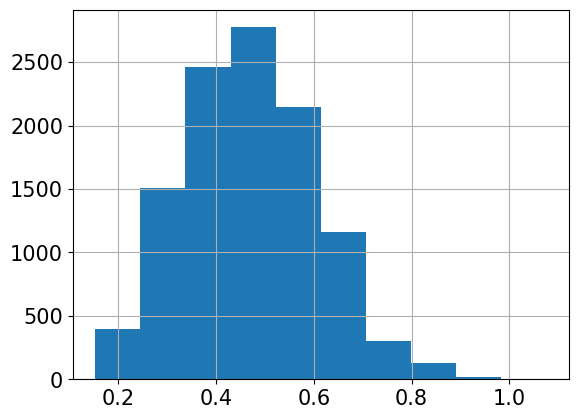

In [216]:
gbif_TRY.iloc[:, 15] = pd.to_numeric(gbif_TRY.iloc[:, 15], errors='coerce')
gbif_TRY.iloc[:, 15].hist()
plt.show()

In [217]:
trait = gbif_TRY.columns[15:]
gbif_TRY[trait] = gbif_TRY[trait].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
gbif_TRY[trait] = np.log(gbif_TRY[trait])
gbif_TRY.head()

C:\Users\teja\AppData\Local\Temp\ipykernel_17860\187295502.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gbif_TRY[trait] = gbif_TRY[trait].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
c:\Users\teja\miniforge3\envs\msc_remote_sens_2024\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,1831133852,34.817678,-115.642178,2017-05-01T04:27:23,Cylindropuntia ramosissima (Engelm.) F.M.Knuth,Plantae,Tracheophyta,Caryophyllales,Cactaceae,Cylindropuntia,...,1.371194,1.115537,3.966075,6.295767,7.358397,8.514826,6.281792,6.654385,5.416932,1.954091
1,2028476084,41.763906,-71.234208,2019-03-17T21:15:57,Juniperus virginiana L.,Plantae,Tracheophyta,Pinales,Cupressaceae,Juniperus,...,3.286208,2.560323,2.227021,5.956809,6.769252,8.687479,4.312630,3.386785,3.820388,0.470929
2,2963846153,45.439163,-73.290246,2020-10-29T08:11:33,Phragmites australis subsp. australis,Plantae,Tracheophyta,Poales,Poaceae,Phragmites,...,0.964195,1.120304,3.856287,5.627448,6.630769,10.415975,6.842373,8.032238,7.934354,0.748403
3,2826220632,57.744264,60.278176,2020-07-29T19:25:59,Sanguisorba officinalis L.,Plantae,Tracheophyta,Rosales,Rosaceae,Sanguisorba,...,0.255116,1.076163,5.241331,5.982212,6.849258,8.816813,7.842883,7.349957,7.776992,0.743314
4,1883535355,34.858802,-80.870275,2018-07-15T23:33:31,Solanum carolinense L.,Plantae,Tracheophyta,Solanales,Solanaceae,Solanum,...,1.064204,1.504335,3.695844,6.040066,6.453957,7.989861,7.833045,7.577830,8.182855,1.580165


In [218]:
gbif_TRY = gbif_TRY.replace(-np.inf, np.nan)
gbif_TRY = gbif_TRY.replace(np.inf, np.nan)

In [219]:
gbif_TRY.to_csv("exports/gbif_TRY_log.csv", index=False)

## Number of observations per trait

In [220]:
gbif_TRY.count().round(decimals = 1)

gbifID                                      10948
decimalLatitude                             10948
decimalLongitude                            10948
dateIdentified                              10914
scientificName                              10948
kingdom                                     10948
phylum                                      10948
order                                       10948
family                                      10948
genus                                       10947
hasCoordinate                               10948
species                                     10900
decimalLongitude_cell                       10948
decimalLatitude_cell                        10948
hex                                         10948
Stem specific density (SSD)                 10900
Root rooting depth                          10900
Specific Leaf Area (SLA)                    10900
Leaf carbon (C) per mass                    10900
Leaf nitrogen (N) per mass                  10900


## Density of observations after linking

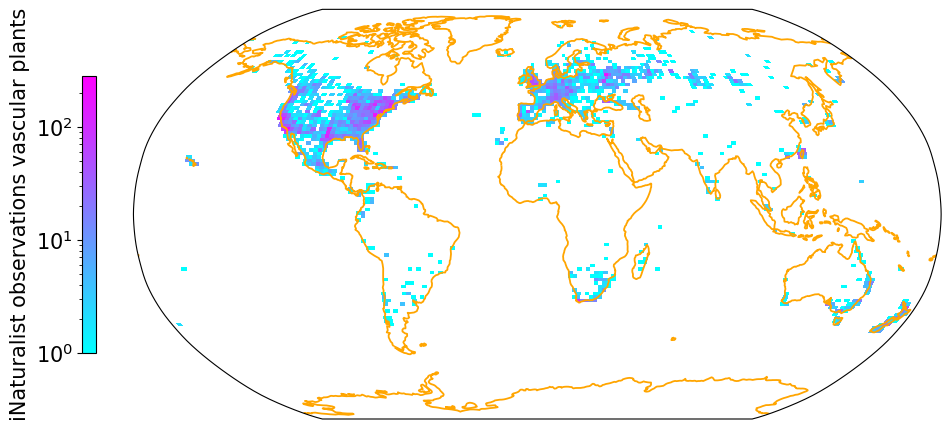

In [221]:
plt.rcParams.update({'font.size': 15})

Z, xedges, yedges = np.histogram2d(np.array(gbif_TRY['decimalLongitude'],dtype=float),
                                   np.array(gbif_TRY['decimalLatitude']),bins = [181, 91])

data_crs = ccrs.PlateCarree()
#for colorbar
cmap = plt.get_cmap('cool')
im_ratio = Z.shape[0]/Z.shape[1]

#plot map
fig = plt.figure(figsize=(12, 12)) # I created a new figure and set up its size

#create base plot of a world map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
ax.set_global()
#add coastlines
ax.coastlines(resolution='110m', color='orange', linewidth=1.3)
#add grid with values
im = ax.pcolormesh(xedges, yedges, Z.T, cmap="cool", norm=LogNorm(), transform=data_crs)
#add color bar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.05)
#fig.colorbar(im, cax=cax)
fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, shrink=0.3, location="left", label="iNaturalist observations vascular plants")


plt.savefig('figures/iNat_density_Robinson_TRY.pdf', bbox_inches='tight')

